In [379]:
import numpy as np
import matplotlib.pyplot as plt
import SQcircuit as sq
import Modules.SQcircuit_extensions as sq_ext
from scipy.optimize import curve_fit, minimize

import pickle
import os
import importlib
importlib.reload(sq_ext)

data_dir = r'/data'
opt_dir = r'/opt_results/'

In [380]:
GHz = 1e9

# Single circuit

We measure qubit 1 (qR7) without a coupler chip (enclosure is empty) in two consecutive cooldowns within a few days (June 2023). There is another chip in enclosure 3, but enclosure 2 is always empty. The chip in enclosure 3 has been changed inbetween cooldown 1 and 2.

## Qubit [ Cooldown 1 ]

In [381]:
experiment_name = 'qubit_1_single_1'


### Load data

In [382]:
with open(os.getcwd() + data_dir + r'/current_extracted__tt_q1_single_circuit_1_up.pkl', 'rb') as f:
    current_extracted__tt_q1_single_circuit_1_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/mw_freq_extracted__tt_q1_single_circuit_1_up.pkl', 'rb') as f:
    mw_freq_extracted__tt_q1_single_circuit_1_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/current_extracted__tt_q1_single_circuit_1_down.pkl', 'rb') as f:
    current_extracted__tt_q1_single_circuit_1_down = pickle.load(f)
with open(os.getcwd() + data_dir + r'/mw_freq_extracted__tt_q1_single_circuit_1_down.pkl', 'rb') as f:
    mw_freq_extracted__tt_q1_single_circuit_1_down = pickle.load(f)
    
current_extracted__tt_q1_single_circuit_1 = np.concatenate([current_extracted__tt_q1_single_circuit_1_down, current_extracted__tt_q1_single_circuit_1_up])
mw_freq_extracted__tt_q1_single_circuit_1 = np.concatenate([mw_freq_extracted__tt_q1_single_circuit_1_down, mw_freq_extracted__tt_q1_single_circuit_1_up])

I0 = (0.008275 + 0.007575)/5
Iss = -0.00035
phase__tt_q1_single_circuit_1  = (current_extracted__tt_q1_single_circuit_1 - Iss + I0/2)/I0
# phase__tt_q1_single_circuit_1  = (current_extracted__tt_q1_single_circuit_1*I_0_inv - Iss*I_0_inv + 1/2)

φ_ext_exp = phase__tt_q1_single_circuit_1
ω_exp = mw_freq_extracted__tt_q1_single_circuit_1

### Define cost function

In [389]:
def qubit_spectrum(parameters, data_set, out='error'):
    CF, LF, EJ, I0, I_origin = parameters
    I, ω_exp = data_set
    
    φ_ext_values  = (I-I_origin)/I0
    
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = fluxonium.loops[0]
    ω_vs_φ_ext = np.zeros(len(φ_ext_values))
    
    for i, φ_ext in enumerate(φ_ext_values):
        loop.set_flux(φ_ext)
        fluxonium.diag(2)
        ω_vs_φ_ext[i] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    
    if out == 'error':
        error = np.sum((ω_vs_φ_ext  - ω_exp * 1e-9)**2)
        print(error)
        return error
    
    elif out == 'spectrum':
        return φ_ext_values, ω_vs_φ_ext *1e9

### Guess parameters and set bounds

In [390]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)
I0_guess = I0
I_origin_guess = Iss - I0/2
parameters_guess = [CF_1, LF_1, EJ_1, I0_guess, I_origin_guess]

free_args_names = ['CF_1', 'LF_1', 'EJ_1', 'I0', 'I_origin']
bounds = ((20,30), (20,30), (4,15), (I0_guess*0.9, I0_guess*1.1), (I_origin_guess*1.1, I_origin_guess*0.9))
data_set = ([current_extracted__tt_q1_single_circuit_1, ω_exp])

### Plot guess to check

Text(0.5, 0, '$\\phi_{ext}$ ($\\phi_0$)')

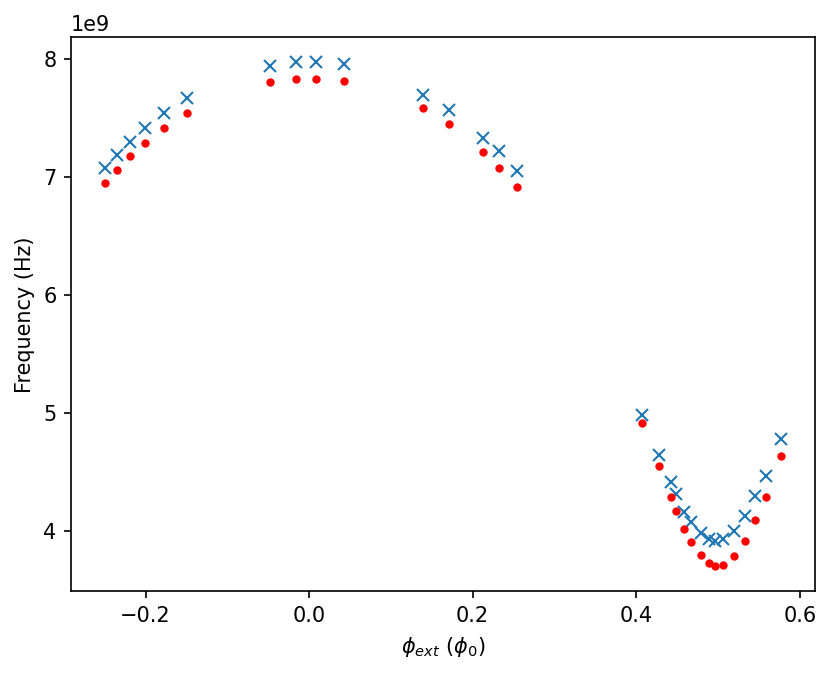

In [391]:
φ_ext_guess, ω_guess = qubit_spectrum(parameters_guess, data_set, out='spectrum')
fig, ax1 = plt.subplots(dpi=150)
ax1.plot(φ_ext_exp, ω_exp, 'x')
ax1.plot(φ_ext_guess, ω_guess, 'r.')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel(r'$\phi_{ext}$ ($\phi_0$)')


### Optimize or load previous optimization

In [397]:
load = False
experiment_name = 'qubit_1_single_1'
experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt   = data['parameters_opt']
    parameters_guess = data['parameters_guess']
    data_set      = (data['data_set'])
    bounds          = (data['bounds'])
else:
    parameters_opt = minimize(qubit_spectrum, parameters_guess, data_set, bounds=bounds, tol = 1e-12).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), bounds=np.array(bounds))

0.718639509087685
0.7186395184430044
0.7186395189704894
0.7186395124202265
0.7186344935444708
0.7186415325683624
1.4839645518597713
1.4839645479019916
1.4839645471576417
1.4839645458607125
1.4840220081178628
1.4837597144743289
0.37533653696655456
0.3753365419165461
0.37533654229112545
0.3753365391375665
0.3753166744014929
0.3752473562918955
0.9496421846839362
0.9496421826904347
0.9496421824112895
0.9496421841286068
0.9497574075960573
0.9498539074462807
0.2799234143621936
0.2799234177211784
0.27992341789455677
0.27992341533885806
0.27994289319834365
0.2799178496041076
0.2707986204074035
0.27079862378177055
0.27079862393288767
0.2707986212412353
0.2708179499057902
0.27079402187093354
0.23675513217451163
0.23675513561466333
0.23675513567552495
0.23675513242562835
0.23677379970172355
0.2367545246492086
0.08282591603777509
0.08282591869224289
0.08282591758422714
0.08282590846353385
0.08282238201211148
0.08283687301426948
0.06748284495406273
0.06748284653489221
0.06748284550844286
0.06748283

In [400]:
print('Guessed parameters \n')
[print(name + f' = {value:.4e}') for name, value in zip(free_args_names, parameters_guess)];
print('\n')
print('Optimized parameters \n')
[print(name + f' = {value:.4e}') for name, value in zip(free_args_names, parameters_opt)];

Guessed parameters 

CF_1 = 2.6900e+01
LF_1 = 2.6500e+01
EJ_1 = 5.4000e+00
I0 = 3.1700e-03
I_origin = -1.9350e-03


Optimized parameters 

CF_1 = 2.6202e+01
LF_1 = 2.5787e+01
EJ_1 = 5.3229e+00
I0 = 3.1639e-03
I_origin = -1.9380e-03


### Plot fits and errors

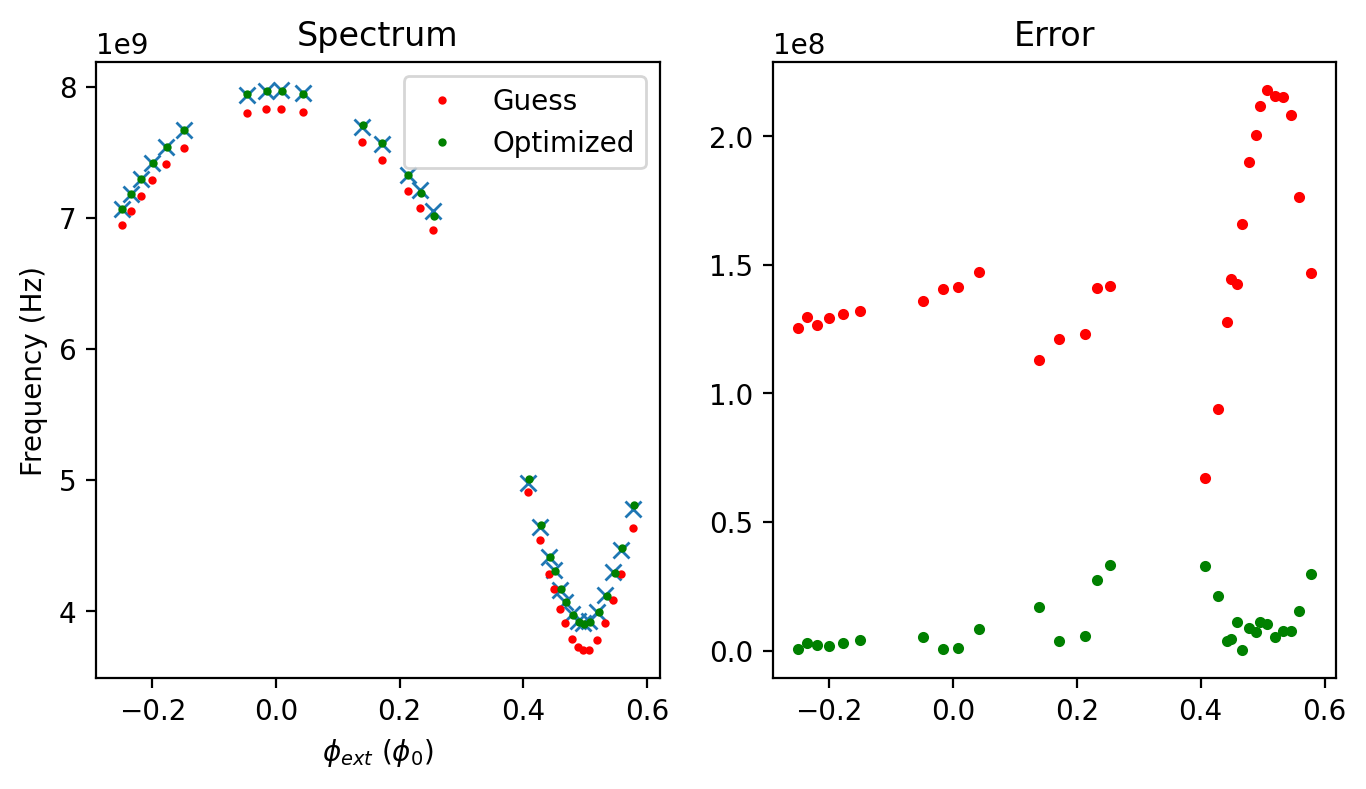

In [399]:
φ_ext_opt, ω_opt   = qubit_spectrum(parameters_opt  , data_set,  out = 'spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp  , ω_exp     , 'x')
ax1.plot(φ_ext_guess, ω_guess   , 'r.', markersize=4, label='Guess')
ax1.plot(φ_ext_opt  , ω_opt     , 'g.', markersize=4, label='Optimized')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax1.set_title('Spectrum')
ax1.legend()
ax2.set_title('Error')

ax2.plot(φ_ext_exp, np.abs(ω_guess-ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt-ω_exp), 'g.')

## Resonator [ Cooldown 1 ]

In [401]:
experiment_name = 'resonator_1_single_1'

### Load data

In [402]:
with open(os.getcwd() + data_dir + r'/current_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    current_q1_single_circuit_1_crossings = pickle.load(f)
with open(os.getcwd() + data_dir + r'/freq_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    freq_q1_single_circuit_1_crossings = pickle.load(f)
    
I0 = (0.008275 + 0.007575)/5
Iss = -0.00035
I = current_q1_single_circuit_1_crossings
φ_ext_exp  = (I - Iss + I0/2)/I0

ω_exp  = freq_q1_single_circuit_1_crossings

### Define cost function

In [410]:
def r_q_av_cross_single_spectrum(parameters, data_set, out='error'):

    CR, LR, Δ, I0, I_origin = parameters
    I, ω_exp, crossing_index_1, crossing_index_2, CF, LF, EJ, nmax_r, nmax_f = data_set
    
    φ_ext_values = (I-I_origin)/I0

    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF,LR=LR,Δ=Δ)
    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR, nmax_r=nmax_r)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, nmax_f=nmax_f)
    loop  = qubit.loops[0]

    ω_vs_φ_ext = np.zeros([len(φ_ext_values),2])
    for i, φ_ext in enumerate(φ_ext_values):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ω_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ω_vs_φ_ext = np.concatenate( [ω_vs_φ_ext[0:crossing_index_1,0] , ω_vs_φ_ext[crossing_index_1:-crossing_index_2,1], ω_vs_φ_ext[-crossing_index_2:,0]]) 
    
    if out == 'error':
        error = np.sum((ω_vs_φ_ext - ω_exp*1e-9)**2)
        print(error)
        return error
    elif out =='spectrum':
        return φ_ext_values, ω_vs_φ_ext* 1e9  

### Guess parameters and set bounds

In [411]:
CF_1, LF_1, EJ_1, I0_guess, I_origin_guess = np.load(os.getcwd() + opt_dir +  'qubit_1_single_1' + '.npz')['parameters_opt']

Δ = 1
LR = 95.1
CR = 6.07
crossing_index_1 = 11
crossing_index_2 = 10
nmax_r=5
nmax_f=15

data_set = ([I, ω_exp, crossing_index_1, crossing_index_2, CF_1, LF_1, EJ_1, nmax_r, nmax_f ])
parameters_guess = [CR, LR, Δ, I0_guess, I_origin_guess]

free_args_names = ['CR_1', 'LR_1', 'Delta', 'I0', 'I_origin']
bounds = ((2,25), (30,170), (0,2), (I0_guess*0.9, I0_guess*1.1), (I_origin_guess*1.1, I_origin_guess*0.9))

### Plot guess to check

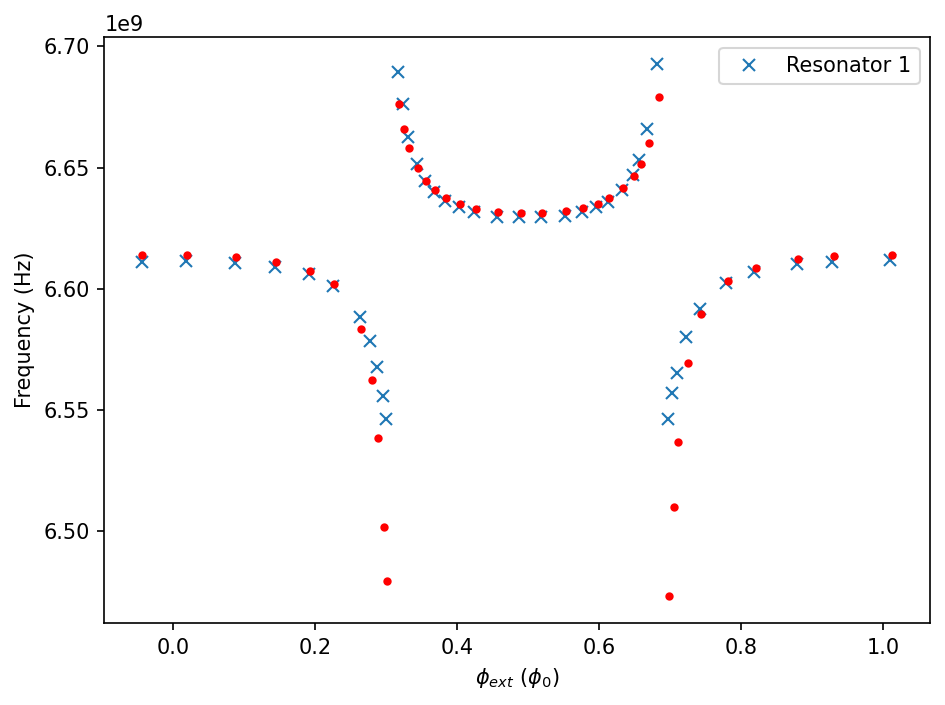

In [412]:
φ_ext_guess, ω_guess = r_q_av_cross_single_spectrum(parameters_guess, data_set, out='spectrum')

fig, ax = plt.subplots(dpi=150)
ax.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax.plot(φ_ext_guess, ω_guess, '.r')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

### Optimize or load previous optimization

In [413]:
load = False
experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt          = data['parameters_opt']
    parameters_guess    = data['parameters_guess']
    data_set            = (data['data_set_arr'], data['data_set_sc'])
    bounds              = (data['bounds'])
else:
    parameters_opt = minimize(r_q_av_cross_single_spectrum, parameters_guess, data_set, bounds=bounds, tol=1e-12).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), bounds=np.array(bounds))

0.017598231489168965
0.017598233442076814
0.017598231610160837
0.01759823218691185
0.01760039492943857
0.01759805962001301
0.5402584124823452
0.5402583633361054
0.5402584094463866
0.5402584124146579
0.5402564417096035
0.5402503327430124
0.012508238391480834
0.012508236035242308
0.012508238238864417
0.01250823890042856
0.012510337362268888
0.01250964333221217
0.26426289106567674
0.26426288342188803
0.2642628905689301
0.2642628932579553
0.26423137610971076
0.26418946009611166
0.011849854393430583
0.011849851695155888
0.011849854219271778
0.011849854867299617
0.011850145369416516
0.011847932584680022
0.011411979301032889
0.011411976862086233
0.011411979143321895
0.011411979778887875
0.011412680285159627
0.011410838954806057
0.01013262445018401
0.010132622637348427
0.010132624332294043
0.010132624920119154
0.010134039829775123
0.010132942873069532
0.007719425229603401
0.00771942429987305
0.007719425168133324
0.007719425652034993
0.007721359200510465
0.007721086839070689
0.00393716475211193

In [414]:
print('Guessed parameters_opt \n')
[print(name + f' = {value:.3e}') for name, value in zip(free_args_names, parameters_guess)];
print('\n')
print('Optimized parameters_opt \n')
[print(name + f' = {value:.3e}') for name, value in zip(free_args_names, parameters_opt)];

Guessed parameters_opt 

CR_1 = 6.070e+00
LR_1 = 9.510e+01
Delta = 1.000e+00
I0 = 3.164e-03
I_origin = -1.938e-03


Optimized parameters_opt 

CR_1 = 6.076e+00
LR_1 = 9.510e+01
Delta = 9.462e-01
I0 = 2.988e-03
I_origin = -1.849e-03


### Plot fits and errors

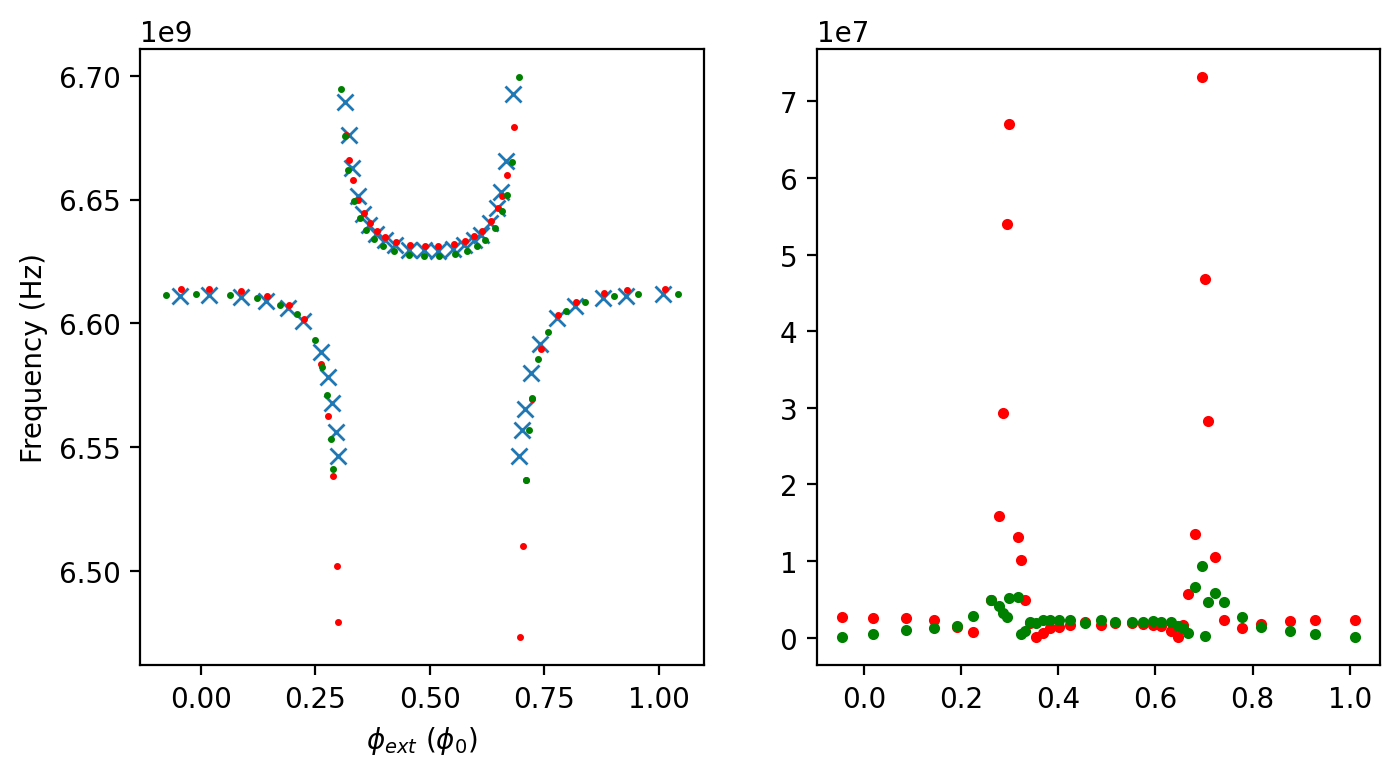

In [415]:
φ_ext_opt, ω_opt = r_q_av_cross_single_spectrum(parameters_opt, data_set, out='spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp  , ω_exp, marker='x', ls='', label='Resonator 1')
ax1.plot(φ_ext_guess, ω_guess, '.r', markersize=3)
ax1.plot(φ_ext_opt  , ω_opt, 'g.', markersize=3)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax2.plot(φ_ext_exp, np.abs(ω_guess - ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt   - ω_exp), 'g.')

## Both at the same time [Cooldown 1]

In [416]:
experiment_name = 'resonator_and_qubit_1_single_1'

### Load data

In [417]:
with open(os.getcwd() + data_dir + r'/current_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    current_q1_single_circuit_1_crossings = pickle.load(f)
with open(os.getcwd() + data_dir + r'/freq_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    freq_q1_single_circuit_1_crossings = pickle.load(f)

with open(os.getcwd() + data_dir + r'/current_extracted__tt_q1_single_circuit_1_up.pkl', 'rb') as f:
    current_extracted__tt_q1_single_circuit_1_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/mw_freq_extracted__tt_q1_single_circuit_1_up.pkl', 'rb') as f:
    mw_freq_extracted__tt_q1_single_circuit_1_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/current_extracted__tt_q1_single_circuit_1_down.pkl', 'rb') as f:
    current_extracted__tt_q1_single_circuit_1_down = pickle.load(f)
with open(os.getcwd() + data_dir + r'/mw_freq_extracted__tt_q1_single_circuit_1_down.pkl', 'rb') as f:
    mw_freq_extracted__tt_q1_single_circuit_1_down = pickle.load(f)
    
IF = np.concatenate([current_extracted__tt_q1_single_circuit_1_down, current_extracted__tt_q1_single_circuit_1_up])
ωF_vs_φ_ext_exp = np.concatenate([mw_freq_extracted__tt_q1_single_circuit_1_down, mw_freq_extracted__tt_q1_single_circuit_1_up])
I0_F = (0.008275 + 0.007575)/5
Iss_F = -0.00035
φ_ext_exp_F  = (IF - Iss_F + I0_F/2)/I0_F

IR = current_q1_single_circuit_1_crossings
ωR_vs_φ_ext_exp  = freq_q1_single_circuit_1_crossings
I0_R = (0.008275 + 0.007575)/5
Iss_R = -0.00035
φ_ext_exp_R  = (IR - Iss_R + I0_R/2)/I0_R

### Define cost function

In [418]:
def unit_cell_single_spectrum(parameters, data_set, out='error'):

    CF, LF, EJ, I0_F, I_origin_F, CR, LR, Δ, I0_R, I_origin_R = parameters
    IF, ωF_vs_φ_ext_exp, IR, ωR_vs_φ_ext_exp, crossing_index_1_F, crossing_index_1_R, crossing_index_2_R, nmax_r, nmax_f = data_set
    
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF ,LR=LR, Δ=Δ)
    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR, nmax_r=nmax_r)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, nmax_f=nmax_f)
    loop  = qubit.loops[0]
    
    φ_ext_R = (IR-I_origin_R)/I0_R
    ωR_vs_φ_ext = np.zeros([len(φ_ext_R),2])
    for i, φ_ext in enumerate(φ_ext_R):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ωR_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ωR_vs_φ_ext = np.concatenate( [ωR_vs_φ_ext[0:crossing_index_1_R,0] , ωR_vs_φ_ext[crossing_index_1_R:-crossing_index_2_R,1], ωR_vs_φ_ext[-crossing_index_2_R:,0]]) 
    
    φ_ext_F  = (IF-I_origin_F)/I0_F
    ωF_vs_φ_ext = np.zeros([len(φ_ext_F),2])
    for i, φ_ext in enumerate(φ_ext_F):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ωF_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ωF_vs_φ_ext = np.concatenate( [ωF_vs_φ_ext[:crossing_index_1_F,0] , ωF_vs_φ_ext[crossing_index_1_F:,1]]) 
    
    
    if out == 'error':
        error = np.sum((ωR_vs_φ_ext - ωR_vs_φ_ext_exp * 1e-9)**2) + np.sum((ωF_vs_φ_ext  - ωF_vs_φ_ext_exp * 1e-9)**2)
        print(error)
        return error
    elif out =='spectrum':
        return φ_ext_F, ωF_vs_φ_ext* 1e9, φ_ext_R, ωR_vs_φ_ext * 1e9 

### Guess parameters and set bounds

In [419]:
CF_1, LF_1, EJ_1, I0_F_1, I_origin_F_1= np.load(os.getcwd() + opt_dir +  'qubit_1_single_1' + '.npz')['parameters_opt']
CR_1, LR_1, Δ_1, I0_R_1, I_origin_R_1 = np.load(os.getcwd() + opt_dir +  'resonator_1_single_1' + '.npz')['parameters_opt']

crossing_index_1_F = 15
crossing_index_1_R = 11
crossing_index_2_R = 10
nmax_r = 5
nmax_f = 15

data_set = ([IF, ωF_vs_φ_ext_exp, IR, ωR_vs_φ_ext_exp, crossing_index_1_F, crossing_index_1_R, crossing_index_2_R, nmax_r, nmax_f])
parameters_guess = [CF_1, LF_1, EJ_1, I0_F_1, I_origin_F_1, CR_1, LR_1, Δ_1, I0_R_1, I_origin_R_1]

free_args_names = ['CF_1', 'LF_1', 'EJ_1', 'I0_F_1', 'I_origin_F_1',
                   'CR_1', 'LR_1', 'Δ_1', 'I0_R_1', 'I_origin_R_1']

bounds = ((20,30), (20,30), (4,15), (I0_F_1*0.9, I0_F_1*1.1), (I_origin_F_1*1.1, I_origin_F_1*0.9), 
          (2,25), (30,170), (0,2), (I0_R_1*0.9, I0_R_1*1.1), (I_origin_R_1*1.1, I_origin_R_1*0.9))

### Plot guess to check

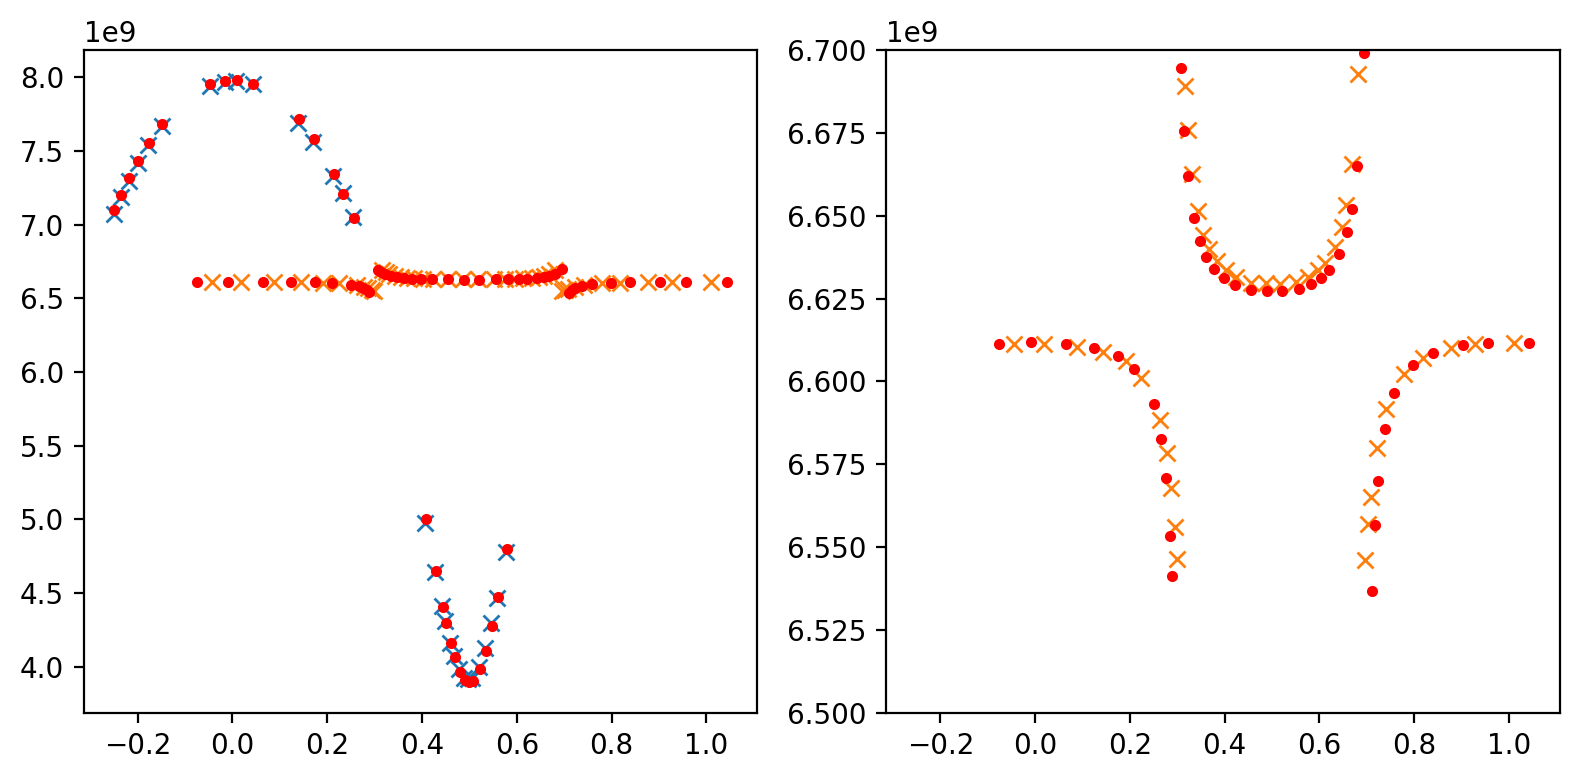

In [420]:
φ_ext_F_guess, ωF_vs_φ_ext_guess, φ_ext_R_guess, ωR_vs_φ_ext_guess = unit_cell_single_spectrum(parameters_guess, data_set, out='spectrum')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[8,4], dpi=200)
for ax in (ax1, ax2):
    ax.plot(φ_ext_exp_F, ωF_vs_φ_ext_exp, 'x')
    ax.plot(φ_ext_exp_R, ωR_vs_φ_ext_exp, 'x')
    ax.plot(φ_ext_F_guess, ωF_vs_φ_ext_guess, '.r')
    ax.plot(φ_ext_R_guess, ωR_vs_φ_ext_guess, '.r')
    
ax2.set_ylim([6.5e9,6.7e9])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()

### Optimize or load previous optimization

In [421]:
load = False
experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt          = data['parameters_opt']
    parameters_guess    = data['parameters_guess']
    data_set            = (data['data_set_arr'], data['data_set_sc'])
    bounds              = (data['bounds'])
else:
    parameters_opt = minimize(unit_cell_single_spectrum, parameters_guess, data_set, bounds=bounds, tol=1e-12).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), bounds=np.array(bounds))

0.0074955443530668586
0.007495544040228109
0.007495544350063376
0.007495546512918622
0.0074969913255769054
0.0074934207283092295
0.007495544311582405
0.0074955443497174
0.007495544493506331
0.007495544413018338
0.007495544538191583
11.336560887600097
11.336560884452586
11.336560885461125
11.336560889723616
11.336644654472106
11.33618304336608
11.336560907414858
11.336560888862557
11.336560888502607
11.336190608979862
11.335796526498378
0.006507580770463904
0.006507580494295256
0.006507580761042587
0.006507582648096638
0.006509687223734129
0.006509163888307025
0.00650758072398172
0.006507580766943917
0.006507580881769109
0.006507260554301692
0.006506967412036143
0.006627870924485274
0.006627870766357829
0.006627870961498957
0.006627872320704633
0.006624250730909106
0.006620628153974161
0.006627870875343892
0.006627870920963249
0.006627871002084276
0.0066269770179735454
0.006626145692665741
0.006067606781571077
0.006067606561152653
0.00606760679424632
0.006067608432451567
0.0060670317750

In [422]:
print('Guessed parameters \n')
[print(name + f' = {value:.3f}') for name, value in zip(free_args_names, parameters_guess)];
print('\n')
print('Optimized parameters \n')
[print(name + f' = {value:.3f}') for name, value in zip(free_args_names, parameters_opt)];

Guessed parameters 

CF_1 = 26.202
LF_1 = 25.787
EJ_1 = 5.323
I0_F_1 = 0.003
I_origin_F_1 = -0.002
CR_1 = 6.076
LR_1 = 95.101
Δ_1 = 0.946
I0_R_1 = 0.003
I_origin_R_1 = -0.002


Optimized parameters 

CF_1 = 26.206
LF_1 = 25.787
EJ_1 = 5.289
I0_F_1 = 0.003
I_origin_F_1 = -0.002
CR_1 = 6.077
LR_1 = 95.101
Δ_1 = 0.944
I0_R_1 = 0.003
I_origin_R_1 = -0.002


### Plot fits and errors

(6500000000.0, 6700000000.0)

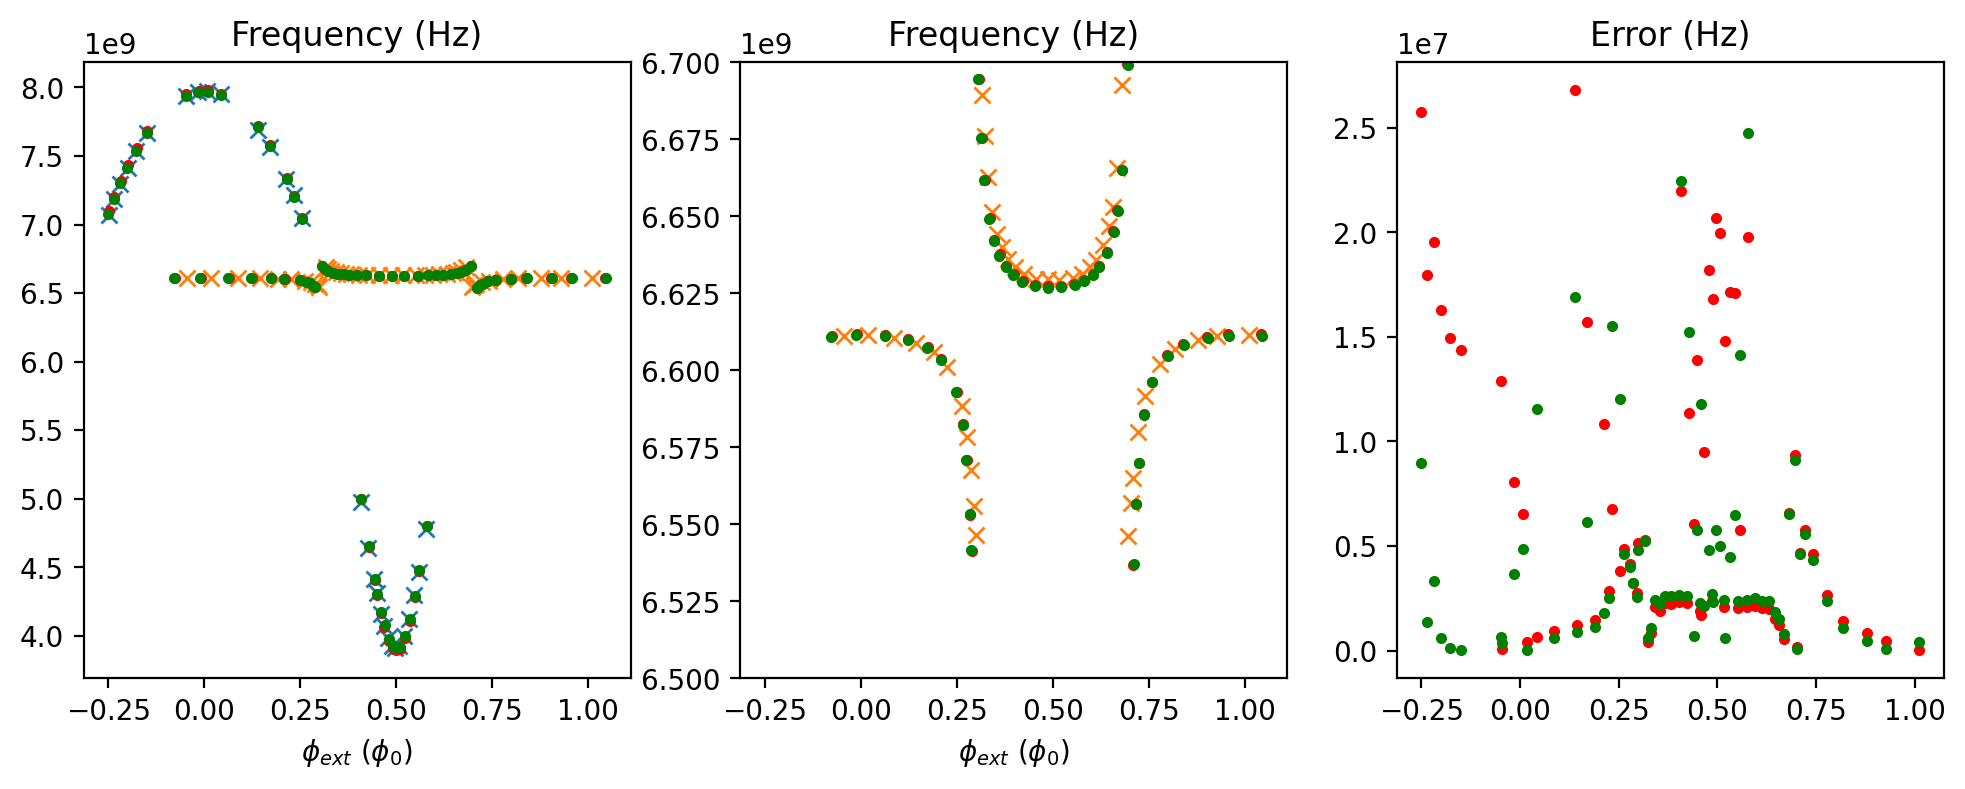

In [423]:
φ_ext_F_opt, ωF_vs_φ_ext_opt, φ_ext_R_opt, ωR_vs_φ_ext_opt = unit_cell_single_spectrum(parameters_opt, data_set, out='spectrum')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[4*3,4], dpi=200)
for ax in (ax1, ax2):
    ax.plot(φ_ext_exp_F     , ωF_vs_φ_ext_exp   , 'x')
    ax.plot(φ_ext_exp_R     , ωR_vs_φ_ext_exp   , 'x')
    ax.plot(φ_ext_F_guess   , ωF_vs_φ_ext_guess , '.r')
    ax.plot(φ_ext_R_guess   , ωR_vs_φ_ext_guess , '.r')
    ax.plot(φ_ext_F_opt     , ωF_vs_φ_ext_opt   , '.g')
    ax.plot(φ_ext_R_opt     , ωR_vs_φ_ext_opt   , '.g')
    ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax3.plot(φ_ext_exp_F, np.abs(ωF_vs_φ_ext_guess - ωF_vs_φ_ext_exp), 'r.')
ax3.plot(φ_ext_exp_R, np.abs(ωR_vs_φ_ext_guess - ωR_vs_φ_ext_exp), 'r.')
ax3.plot(φ_ext_exp_F, np.abs(ωF_vs_φ_ext_opt   - ωF_vs_φ_ext_exp), 'g.')
ax3.plot(φ_ext_exp_R, np.abs(ωR_vs_φ_ext_opt   - ωR_vs_φ_ext_exp), 'g.')
    
ax1.set_title('Frequency (Hz)')
ax2.set_title('Frequency (Hz)')
ax3.set_title('Error (Hz)')
ax2.set_ylim([6.5e9,6.7e9])


## Both at the same time [Cooldown 2]

In [369]:
experiment_name = 'resonator_and_qubit_1_single_2'

### Load data

In [365]:
with open(os.getcwd() + data_dir + r'/current_q1_single_circuit_2_crossings.pkl', 'rb') as f:
    current_q1_single_circuit_2_crossings = pickle.load(f)
with open(os.getcwd() + data_dir + r'/freq_q1_single_circuit_2_crossings.pkl', 'rb') as f:
    freq_q1_single_circuit_2_crossings = pickle.load(f)

with open(os.getcwd() + data_dir + r'/current_extracted__tt_q1_single_circuit_2.pkl', 'rb') as f:
    current_extracted__tt_q1_single_circuit_2 = pickle.load(f)
with open(os.getcwd() + data_dir + r'/mw_freq_extracted__tt_q1_single_circuit_2.pkl', 'rb') as f:
    mw_freq_extracted__tt_q1_single_circuit_2= pickle.load(f)
    
IF = current_extracted__tt_q1_single_circuit_2 
ωF_vs_φ_ext_exp = mw_freq_extracted__tt_q1_single_circuit_2
I0_F = (0.00825 + 0.00762)/5
Iss_F =  0.0013
φ_ext_exp_F  = (IF - Iss_F + I0_F/2)/I0_F

IR = current_q1_single_circuit_2_crossings
ωR_vs_φ_ext_exp  = freq_q1_single_circuit_2_crossings
I0_R = (0.00825 + 0.00762)/5
Iss_R =  0.001285
φ_ext_exp_R  = (IR - Iss_R + I0_R/2)/I0_R

### Define cost function

In [366]:
def unit_cell_single_spectrum(parameters, data_set, out='error'):

    CF, LF, EJ, I0_F, I_origin_F, CR, LR, Δ, I0_R, I_origin_R = parameters
    IF, ωF_vs_φ_ext_exp, IR, ωR_vs_φ_ext_exp, crossing_index_1_F, crossing_index_1_R, crossing_index_2_R, nmax_r, nmax_f = data_set
    
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF ,LR=LR, Δ=Δ)
    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR, nmax_r=nmax_r)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ, nmax_f=nmax_f)
    loop  = qubit.loops[0]
    
    φ_ext_R = (IR-I_origin_R)/I0_R
    ωR_vs_φ_ext = np.zeros([len(φ_ext_R),2])
    for i, φ_ext in enumerate(φ_ext_R):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ωR_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ωR_vs_φ_ext = np.concatenate( [ωR_vs_φ_ext[0:crossing_index_1_R,0] , ωR_vs_φ_ext[crossing_index_1_R:-crossing_index_2_R,1], ωR_vs_φ_ext[-crossing_index_2_R:,0]]) 
    
    φ_ext_F  = (IF-I_origin_F)/I0_F
    ωF_vs_φ_ext = np.zeros(len(φ_ext_F))
    for i, φ_ext in enumerate(φ_ext_F):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ωF_vs_φ_ext[i] = sq_ext.diag(H, 2, remove_ground=True)[0][1]
    
    
    if out == 'error':
        error = np.sum((ωR_vs_φ_ext - ωR_vs_φ_ext_exp * 1e-9)**2) + np.sum((ωF_vs_φ_ext  - ωF_vs_φ_ext_exp * 1e-9)**2)
        print(error)
        return error
    elif out =='spectrum':
        return φ_ext_F, ωF_vs_φ_ext* 1e9, φ_ext_R, ωR_vs_φ_ext * 1e9 

### Guess parameters and set bounds

In [370]:
CF_1, LF_1, EJ_1, _, _, CR_1, LR_1, Δ_1, _, _ = np.load(os.getcwd() + opt_dir +  'resonator_and_qubit_1_single_1' + '.npz')['parameters_opt']

I0_F_1 = I0_F
I_origin_F_1 = Iss_F - I0_F/2

I0_R_1 = I0_R
I_origin_R_1 = Iss_R - I0_R/2

crossing_index_1_F = 15
crossing_index_1_R = 11
crossing_index_2_R = 10
nmax_r = 5
nmax_f = 15

data_set = ([IF, ωF_vs_φ_ext_exp, IR, ωR_vs_φ_ext_exp, crossing_index_1_F, crossing_index_1_R, crossing_index_2_R, nmax_r, nmax_f])
parameters_guess = [CF_1, LF_1, EJ_1, I0_F_1, I_origin_F_1, CR_1, LR_1, Δ_1, I0_R_1, I_origin_R_1]

free_args_names = ['CF_1', 'LF_1', 'EJ_1', 'I0_F_1', 'I_origin_F_1',
                   'CR_1', 'LR_1', 'Δ_1', 'I0_R_1', 'I_origin_R_1']

bounds = ((20,30), (20,30), (4,15), (I0_F_1*0.9, I0_F_1*1.1), (I_origin_F_1*1.1, I_origin_F_1*0.9), 
          (2,25), (30,170), (0,2), (I0_R_1*0.9, I0_R_1*1.1), (I_origin_R_1*1.1, I_origin_R_1*0.9))

### Plot guess to check

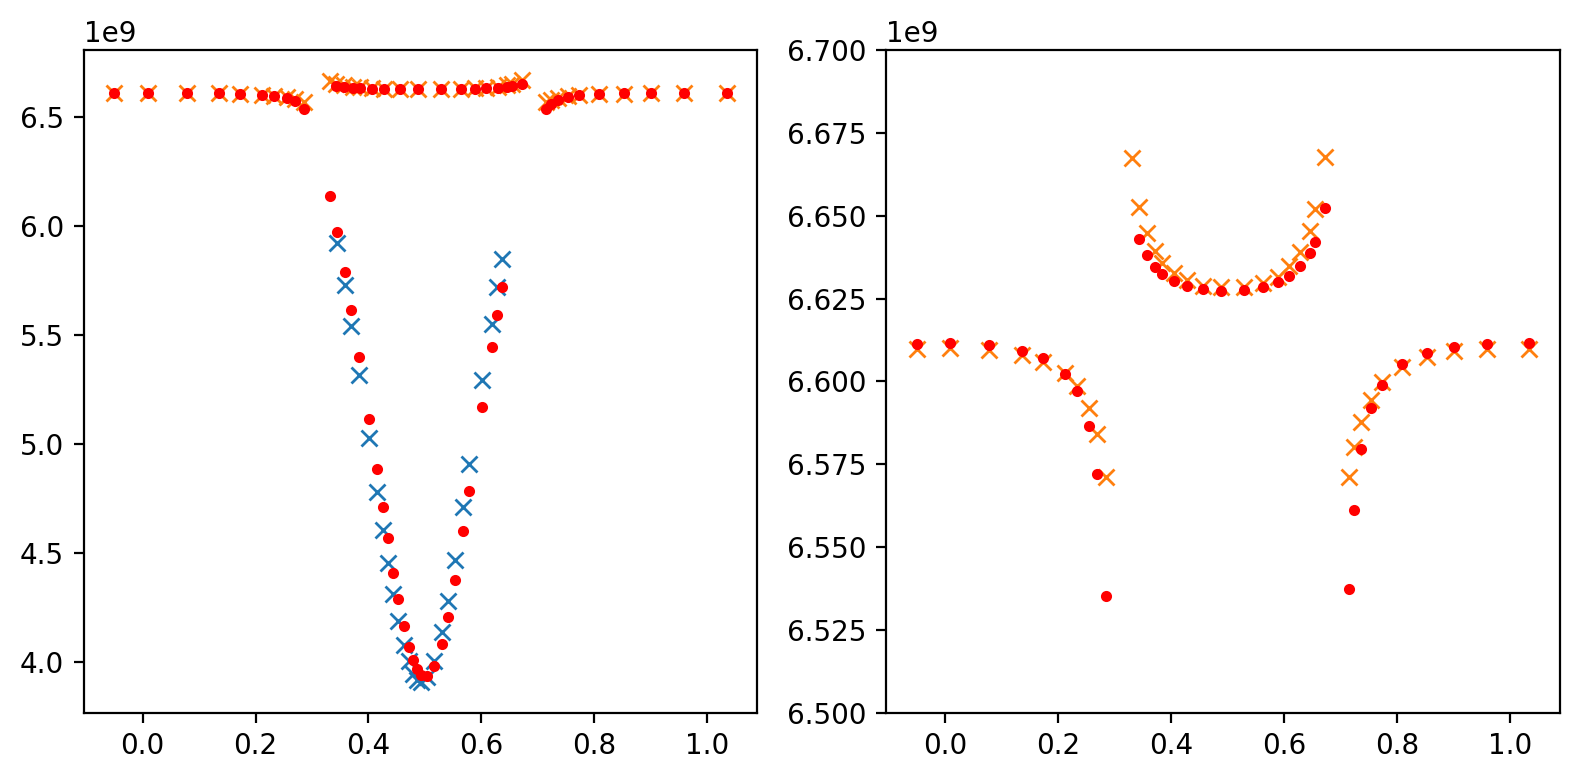

In [372]:
φ_ext_F_guess, ωF_vs_φ_ext_guess, φ_ext_R_guess, ωR_vs_φ_ext_guess = unit_cell_single_spectrum(parameters_guess, data_set, out='spectrum')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[8,4], dpi=200)
for ax in (ax1, ax2):
    ax.plot(φ_ext_exp_F, ωF_vs_φ_ext_exp, 'x')
    ax.plot(φ_ext_F_guess, ωF_vs_φ_ext_guess, '.r')
    ax.plot(φ_ext_exp_R, ωR_vs_φ_ext_exp, 'x')
    ax.plot(φ_ext_R_guess, ωR_vs_φ_ext_guess, '.r')
    
ax2.set_ylim([6.5e9,6.7e9])
#ax.set_ylabel(r'$')
#ax.set_xlabel(r'$')
#ax.set_title(r'$')
fig.tight_layout()

### Optimize or load previous optimization

In [373]:
load = False
experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt      = data['parameters_opt']
    parameters_guess    = data['parameters_guess']
    data_set            = (data['data_set_arr'], data['data_set_sc'])
    bounds              = (data['bounds'])
else:
    parameters_opt = minimize(unit_cell_single_spectrum, parameters_guess, data_set, bounds=bounds).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), bounds=np.array(bounds))

0.4876126310423289
0.4876126318045084
0.48761263118095727
0.4876126262094178
0.487707835724583
0.4878024927115101
0.48761263291149304
0.487612631158135
0.4876126317591021
0.48759986164098584
0.48757263030030273
18.47161743626826
18.471617433049115
18.471617440624918
18.471617490016115
18.470648688688804
18.469874577927254
18.4716173819143
18.471617432936924
18.471617428931598
18.47151342705298
18.471455195994093
0.22424470923394935
0.22424471007428842
0.22424470972547234
0.22424470653628178
0.22424842747925647
0.22425329779719383
0.22424470748194464
0.22424470911893082
0.22424470994462362
0.22423541397438945
0.22421334318041639
0.20477173682988012
0.20477173763019893
0.20477173736761817
0.2047717348413383
0.20476027975889444
0.20475137832215942
0.20477173404199606
0.2047717366489852
0.2047717375497488
0.20476440767568363
0.20474473941990032
0.1801280362031002
0.18012803695040094
0.1801280367715637
0.18012803494803348
0.1801109179591551
0.18009835078823405
0.18012803207799288
0.18012803

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

In [376]:
print('Guessed parameters \n')
[print(name + f' = {value:.3f}') for name, value in zip(free_args_names, parameters_guess)];
print('\n')
print('Optimized parameters \n')
[print(name + f' = {value:.3f}') for name, value in zip(free_args_names, parameters_opt)];

Guessed parameters 

CF_1 = 26.304
LF_1 = 25.871
EJ_1 = 5.188
I0_F_1 = 0.003
I_origin_F_1 = -0.000
CR_1 = 6.075
LR_1 = 95.110
Δ_1 = 0.944
I0_R_1 = 0.003
I_origin_R_1 = -0.000


Optimized parameters 

CF_1 = 26.291
LF_1 = 25.868
EJ_1 = 5.275
I0_F_1 = 0.003
I_origin_F_1 = -0.000
CR_1 = 6.041
LR_1 = 95.108
Δ_1 = 0.931
I0_R_1 = 0.003
I_origin_R_1 = -0.000


### Plot fits and errors

(6500000000.0, 6700000000.0)

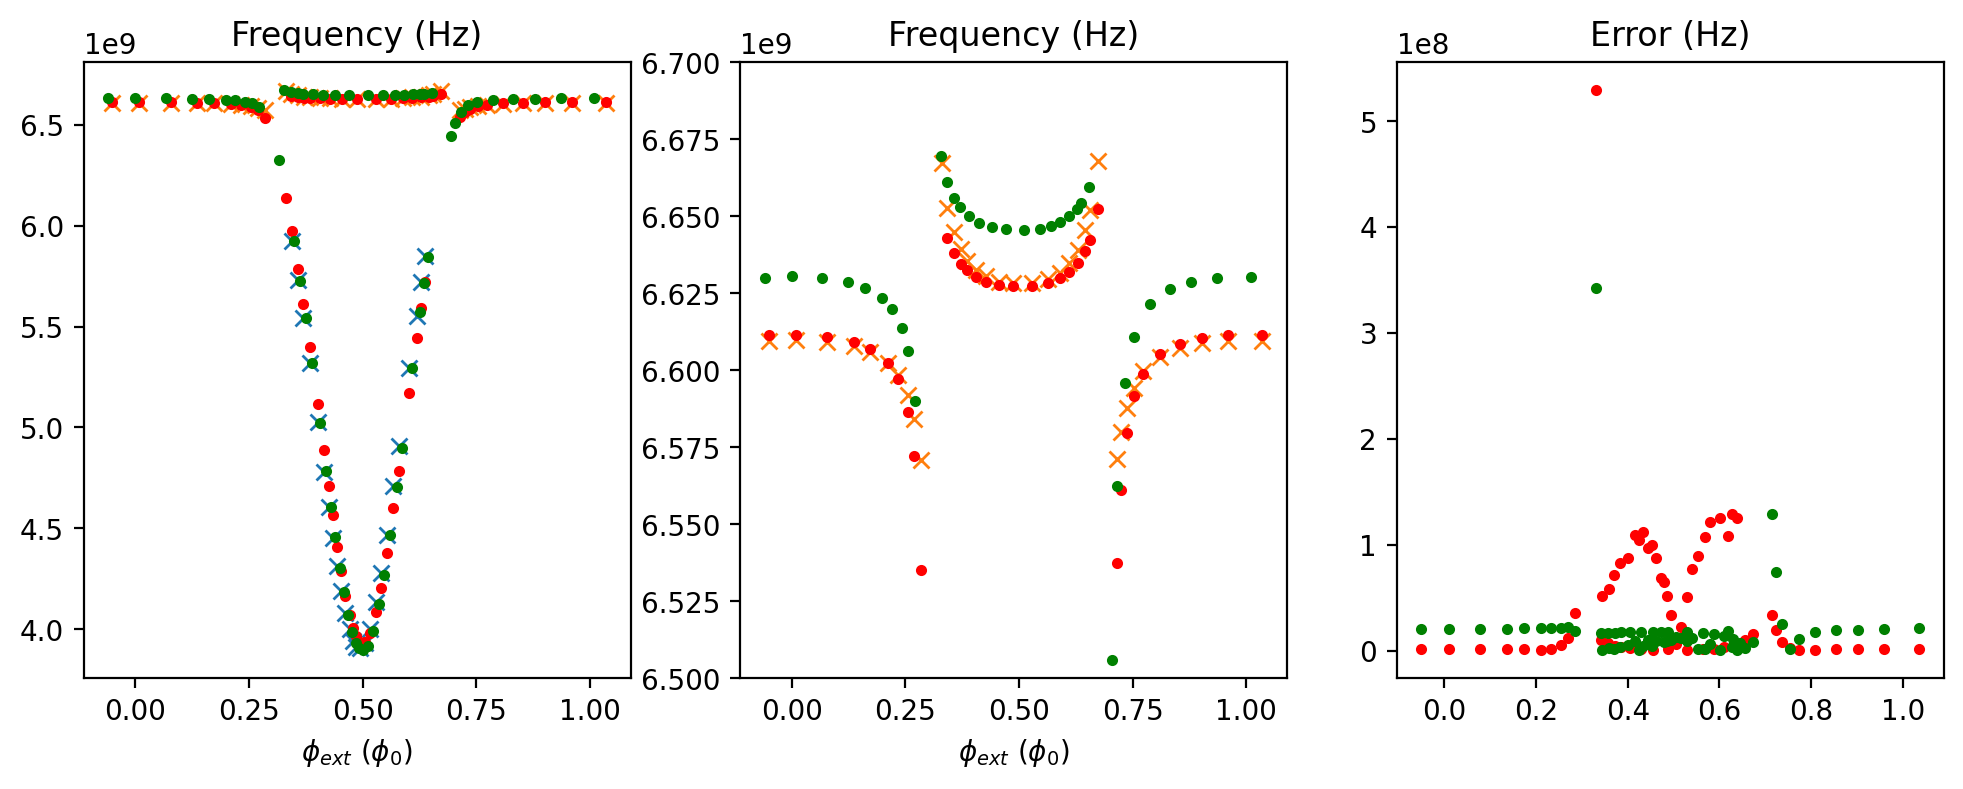

In [378]:
φ_ext_F_opt, ωF_vs_φ_ext_opt, φ_ext_R_opt, ωR_vs_φ_ext_opt = unit_cell_single_spectrum(parameters_opt, data_set, out='spectrum')

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=[4*3,4], dpi=200)
for ax in (ax1, ax2):
    ax.plot(φ_ext_exp_F     , ωF_vs_φ_ext_exp   , 'x')
    ax.plot(φ_ext_exp_R     , ωR_vs_φ_ext_exp   , 'x')
    ax.plot(φ_ext_F_guess   , ωF_vs_φ_ext_guess , '.r')
    ax.plot(φ_ext_R_guess   , ωR_vs_φ_ext_guess , '.r')
    ax.plot(φ_ext_F_opt     , ωF_vs_φ_ext_opt   , '.g')
    ax.plot(φ_ext_R_opt     , ωR_vs_φ_ext_opt   , '.g')
    ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax3.plot(φ_ext_exp_F, np.abs(ωF_vs_φ_ext_guess - ωF_vs_φ_ext_exp), 'r.')
ax3.plot(φ_ext_exp_R, np.abs(ωR_vs_φ_ext_guess - ωR_vs_φ_ext_exp), 'r.')
ax3.plot(φ_ext_exp_F, np.abs(ωF_vs_φ_ext_opt   - ωF_vs_φ_ext_exp), 'g.')
ax3.plot(φ_ext_exp_R, np.abs(ωR_vs_φ_ext_opt   - ωR_vs_φ_ext_exp), 'g.')
    
ax1.set_title('Frequency (Hz)')
ax2.set_title('Frequency (Hz)')
ax3.set_title('Error (Hz)')
ax2.set_ylim([6.5e9,6.7e9])


# Qubit 1

In [10]:
experiment_name = 'qubit_1'


### Load data

In [11]:
with open(os.getcwd() + data_dir + r'/x__q1_tt_low_q1.pkl', 'rb') as f:
    x__q1_tt_low = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/y__q1_tt_low_q1.pkl', 'rb') as f:
    y__q1_tt_low = pickle.load(f)[0]
    
with open(os.getcwd() + data_dir + r'/x__q1_tt_up_q1.pkl', 'rb') as f:
    x__q1_tt_up = pickle.load(f)
with open(os.getcwd() + data_dir + r'/y__q1_tt_up_q1.pkl', 'rb') as f:
    y__q1_tt_up = pickle.load(f)

Anzahl_Perioden = 2
I_ss_low__fs = -0.00375
I_ss_up__fs = 0.00267
I0_q1 = (I_ss_up__fs - I_ss_low__fs)/Anzahl_Perioden    
I_ss__q1_tt_low = 1e-5

x__q1_tt = np.concatenate([x__q1_tt_low, x__q1_tt_up])
y__q1_tt = np.concatenate([y__q1_tt_low, y__q1_tt_up])
phi_q1_tt = (x__q1_tt - I_ss__q1_tt_low + I0_q1/2  ) /I0_q1

φ_ext_exp = phi_q1_tt
ω_exp = y__q1_tt

## Define cost function

In [12]:
def qubit_spectrum(free_args, data_set, out='error'):
    CF, LF, EJ = free_args
    φ_ext_exp, ω_exp = data_set
    # φ_ext_values = phi_q1_tt
    fluxonium = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = fluxonium.loops[0]
    ω_vs_φ_ext = np.zeros(len(φ_ext_exp))
    
    for i, φ_ext in enumerate(φ_ext_exp):
        loop.set_flux(φ_ext)
        fluxonium.diag(2)
        ω_vs_φ_ext[i] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
    
    if out == 'error':
        return np.sum((ω_vs_φ_ext * 1e9 - ω_exp)**2)
    elif out == 'spectrum':
        return ω_vs_φ_ext * 1e9 

## Guess parameters and set bounds

In [13]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)
parameters_guess = [CF_1, LF_1, EJ_1]
free_args_names = ['CF_1', 'LF_1', 'EJ_1']
bounds = ((20,30), (20,30), (4,15))
data_set = ([φ_ext_exp, ω_exp])

## Plot guess to check

Text(0.5, 0, '$\\phi_{ext}$ ($\\phi_0$)')

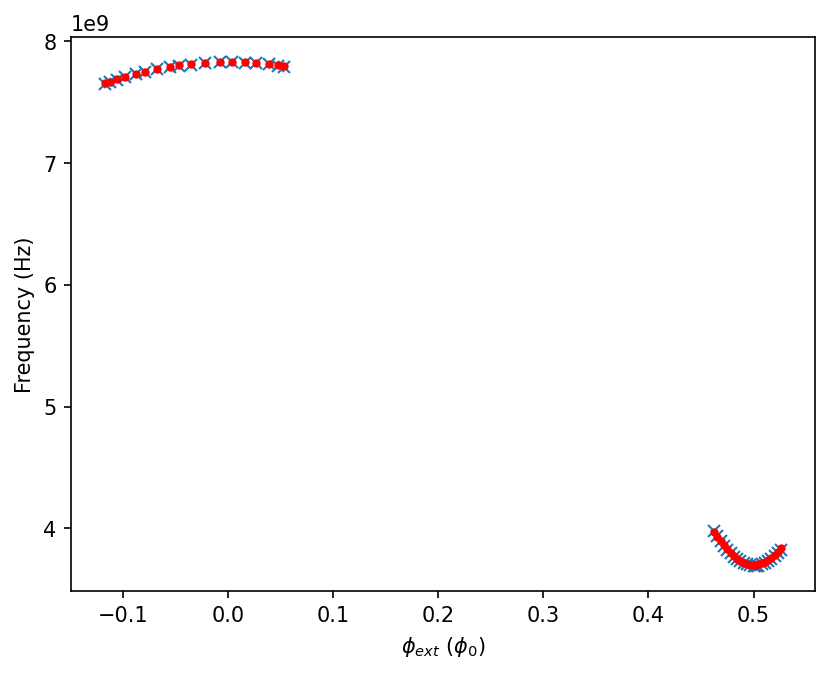

In [23]:
ω_guess = qubit_spectrum(parameters_guess, data_set, out='spectrum')
fig, ax1 = plt.subplots(dpi=150)
ax1.plot(φ_ext_exp, ω_exp, 'x')
ax1.plot(φ_ext_exp, ω_guess, 'r.')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel(r'$\phi_{ext}$ ($\phi_0$)')


## Optimize or load previous optimization

In [21]:
load = True

experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt   = data['parameters_opt']
    parameters_guess = data['parameters_guess']
    data_set      = (data['data_set'])
    bounds          = (data['bounds'])
else:
    parameters_opt = minimize(qubit_spectrum, parameters_guess, data_set, bounds=bounds).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), data_set=np.array(data_set), bounds=np.array(bounds))

[print(name + f' = {value:.3f}') for name, value in zip(free_args_names, parameters_opt)];

CF_1 = 28.462
LF_1 = 25.032
EJ_1 = 5.635


## Plot fits and errors

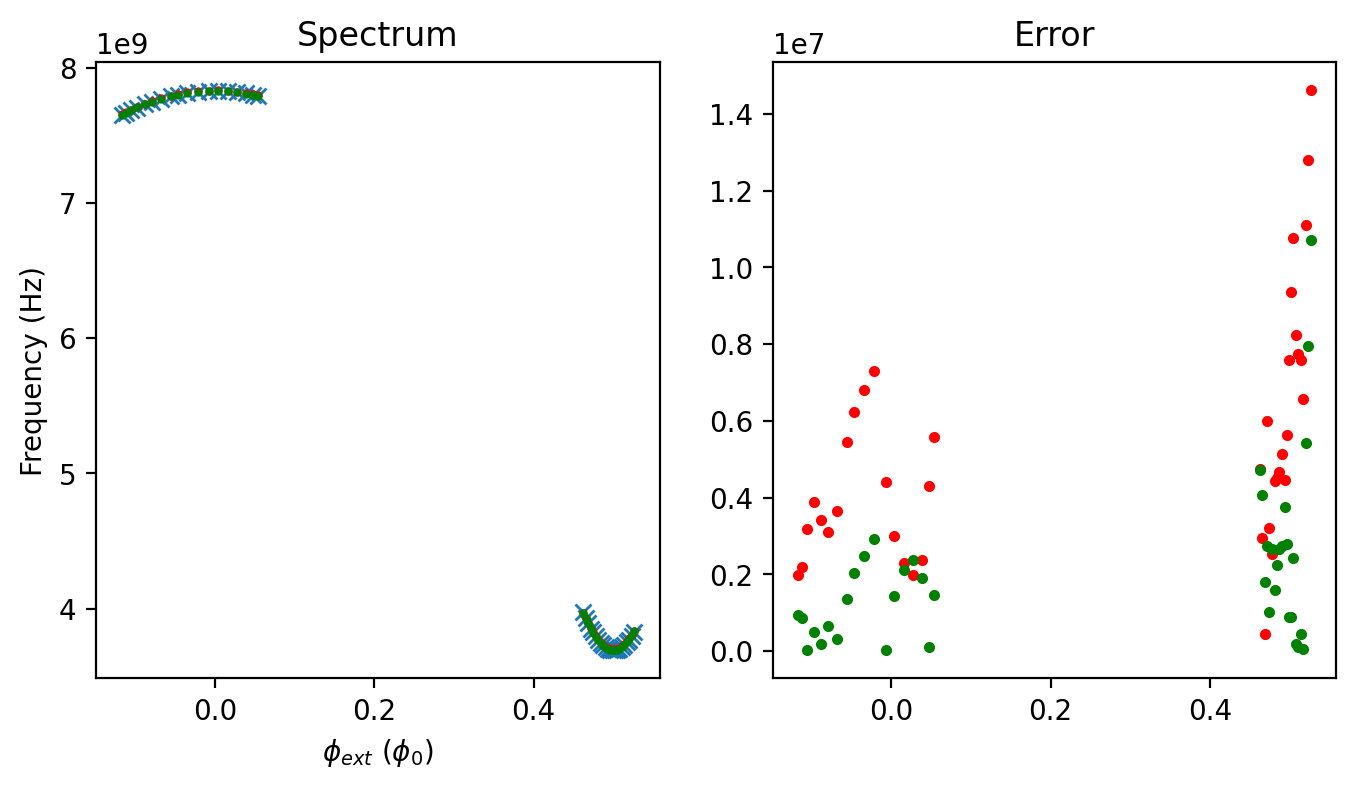

In [25]:
ω_opt   = qubit_spectrum(parameters_opt  , data_set,  out = 'spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp, ω_exp, 'x')
ax1.plot(φ_ext_exp, ω_guess, 'r.', markersize=4)
ax1.plot(φ_ext_exp, ω_opt, 'g.', markersize=4)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax1.set_title('Spectrum')
ax2.set_title('Error')

ax2.plot(φ_ext_exp, np.abs(ω_guess-ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt-ω_exp), 'g.')

# Qubit 1 - Resonator 1 avoided level crossing

In [375]:
experiment_name = 'qubit_1_resonator_1_avoided_level_crossing'

### Load data

In [280]:
with open(os.getcwd() + data_dir + r'/f_vna__fs_q1_coil1.pkl', 'rb') as f:
    f_vna__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/current__fs_q1_coil1.pkl', 'rb') as f:
    current__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/phase__fs_q1_coil1.pkl', 'rb') as f:
    phase__fs_q1_coil1 = pickle.load(f)[0]
with open(os.getcwd() + data_dir + r'/current__fres_q1_coil1.pkl', 'rb') as f:
    current_q1_coil1 = pickle.load(f)
with open(os.getcwd() + data_dir + r'/fres__fres_q1_coil1.pkl', 'rb') as f:
    fres_q1_coil1 = pickle.load(f)
    
current_q1_coil1 = np.concatenate([current_q1_coil1[0], current_q1_coil1[1], current_q1_coil1[2]])
fres_q1_coil1 = np.concatenate([fres_q1_coil1[0], fres_q1_coil1[1], fres_q1_coil1[2]])
I_ss__q1_fs = 1.12*1e-5
phi_q1_coil1 = (current_q1_coil1 - I_ss__q1_fs + I0_q1 / 2) / I0_q1

φ_ext_exp = phi_q1_coil1
ω_exp = fres_q1_coil1

## Define cost function

In [306]:
def r_q_av_cross_spectrum(free_args, data_set, out='error'):
    CR, LR, EJ, Δ, C_int = free_args
    φ_ext_exp, ω_exp, CF, LF = data_set
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_1,LR=LR,Δ=Δ)

    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = qubit.loops[0]

    ω_vs_φ_ext = np.zeros([len(φ_ext_exp),2])
    for i, φ_ext in enumerate(φ_ext_exp):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ, C_int=C_int )
        ω_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ω_vs_φ_ext = np.concatenate( [ω_vs_φ_ext[0:13,0] , ω_vs_φ_ext[13:-10,1], ω_vs_φ_ext[-10:,0]]) * 1e9 
    
    if out == 'error':
        return np.sum((ω_vs_φ_ext - ω_exp)**2)
    elif out =='spectrum':
        return ω_vs_φ_ext 

## Guess parameters and set bounds

In [307]:
_, CF_1, LF_1, _, _, _, _ = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)

experiment_file = os.getcwd() + opt_dir + 'qubit_1' + '.npz'
data = np.load(experiment_file)
EJ = data['parameters_opt'][-1]

Δ=0.7
LR = 100
C_int = 370
CR, _, _, _, _, _, _ = sq_ext.get_experimental_parameters('qubit 1', Δ=Δ, LR=LR)
CR-=0.05
LR-=0.3
parameters_guess = [CR, LR, EJ, Δ, C_int]
data_set = ([φ_ext_exp, ω_exp, CF_1, LF_1 ])
bounds= ((2,25),(30,170),(4,15),(0,1),(10,1000))

## Plot guess to check

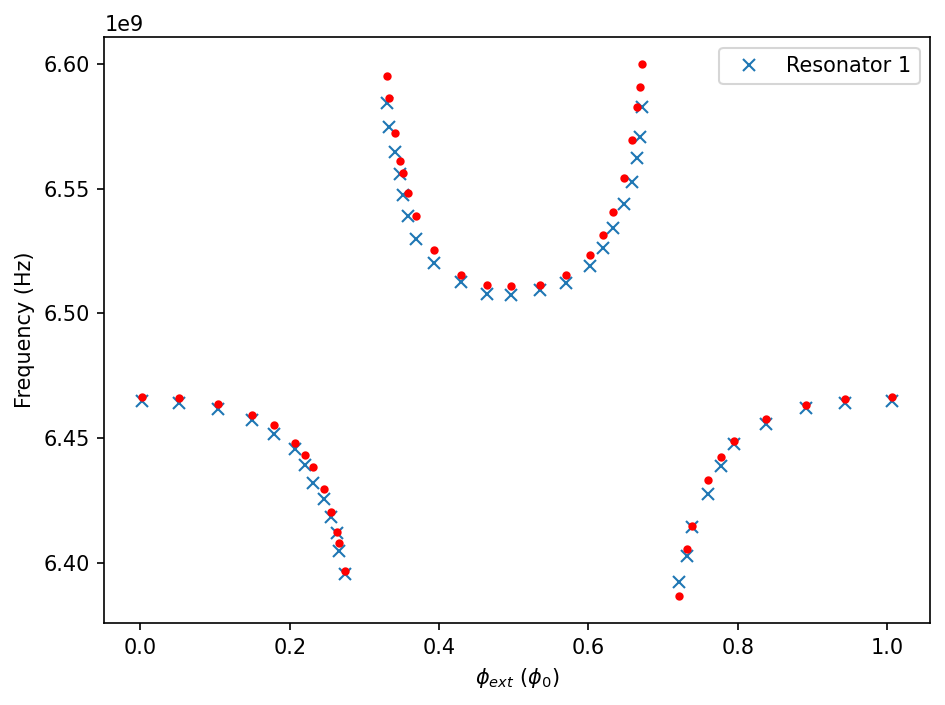

In [308]:
ω_guess = r_q_av_cross_spectrum(parameters_guess, data_set, out='spectrum')

fig, ax = plt.subplots(dpi=150)
ax.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax.plot(φ_ext_exp, ω_guess, '.r')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

## Optimize or load previous optimization

In [376]:
load = True
experiment_name = 'qubit_1_resonator_1_avoided_level_crossing'

experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters_opt   = data['parameters_opt']
    parameters_guess = data['parameters_guess']
    data_set      = (data['data_set_arr'], data['data_set_sc'])
    bounds          = (data['bounds'])
else:
    parameters_opt = minimize(r_q_av_cross_spectrum, parameters_guess, data_set, bounds=bounds).x
    np.savez(experiment_file, parameters_opt=parameters_opt, parameters_guess = np.array(parameters_guess), data_set_arr=np.array(data_set[0:2]), 
             data_set_sc=np.array(data_set[2:]), bounds=np.array(bounds))
    

## Plot fits and errors

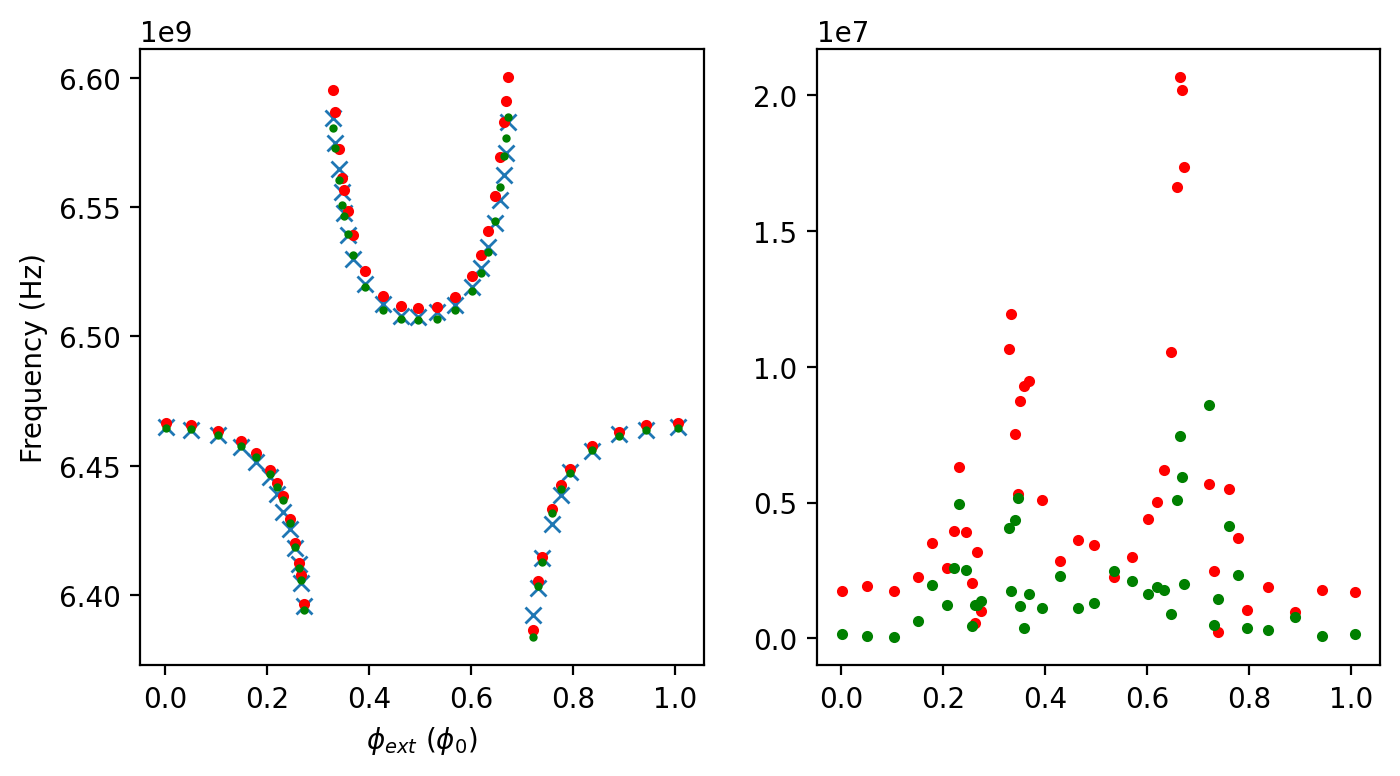

In [315]:
ω_opt = r_q_av_cross_spectrum(parameters, data_set, out='spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax1.plot(φ_ext_exp, ω_guess, '.r')
ax1.plot(φ_ext_exp, ω_opt, 'g.', markersize=4)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax2.plot(φ_ext_exp, np.abs(ω_guess - ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt   - ω_exp), 'g.')

# Qubit 1 - Resonator 1 avoided level crossing [Single circuit cooldown 1]

In [512]:
experiment_name = 'qubit_1_resonator_1_avoided_level_crossing_single_circuit_1'

### Load data

In [513]:
with open(os.getcwd() + data_dir + r'/current_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    current_q1_single_circuit_1_crossings = pickle.load(f)
with open(os.getcwd() + data_dir + r'/freq_q1_single_circuit_1_crossings.pkl', 'rb') as f:
    freq_q1_single_circuit_1_crossings = pickle.load(f)
I0 = (0.008275 + 0.007575)/5
Iss = -0.00035
phase_q1_crossings_CD1 = (current_q1_single_circuit_1_crossings - Iss + I0/2)/I0
φ_ext_exp = phase_q1_crossings_CD1
ω_exp = freq_q1_single_circuit_1_crossings

## Define cost function

In [514]:
def r_q_av_cross_single_spectrum(free_args, data_set, out='error'):
    CR, LR, EJ, Δ = free_args
    φ_ext_exp, ω_exp, CF, LF, crossing_index_1, crossing_index_2 = data_set
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_1,LR=LR,Δ=Δ)

    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = qubit.loops[0]

    ω_vs_φ_ext = np.zeros([len(φ_ext_exp),2])
    for i, φ_ext in enumerate(φ_ext_exp):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ω_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ω_vs_φ_ext = np.concatenate( [ω_vs_φ_ext[0:crossing_index_1,0] , ω_vs_φ_ext[crossing_index_1:-crossing_index_2,1], ω_vs_φ_ext[-crossing_index_2:,0]]) * 1e9 
    
    if out == 'error':
        return np.sum((ω_vs_φ_ext - ω_exp)**2)
    elif out =='spectrum':
        return ω_vs_φ_ext 

## Guess parameters and set bounds

In [515]:
_, CF_1, LF_1, _, _, _, _ = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)

# experiment_file = os.getcwd() + opt_dir + 'qubit_1' + '.npz'
# data = np.load(experiment_file)
# EJ = data['parameters'][-1]
EJ = 6.24
Δ = 0.8
LR = 95
CR = 6.07

In [516]:
crossing_index_1 = 11
crossing_index_2 = 10
parameters_guess = [CR, LR, EJ, Δ]
data_set = ([φ_ext_exp, ω_exp, CF_1, LF_1,crossing_index_1, crossing_index_2 ])
bounds= ((2,25),(30,170),(4,15),(0,2))

## Plot guess to check

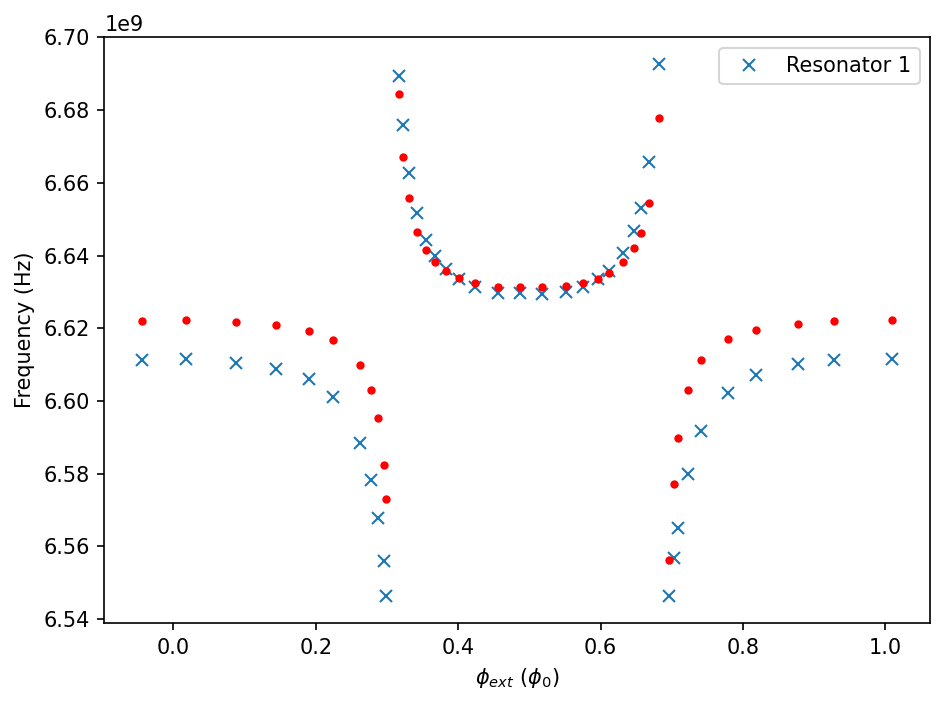

In [517]:
ω_guess = r_q_av_cross_single_spectrum(parameters_guess, data_set, out='spectrum')

fig, ax = plt.subplots(dpi=150)
ax.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax.plot(φ_ext_exp, ω_guess, '.r')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

## Optimize or load previous optimization

In [518]:
load = False

experiment_name = 'qubit_1_resonator_1_avoided_level_crossing_single_circuit_1'
experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters   = data['parameters']
    parameters_guess = data['parameters_guess']
    data_set      = (data['data_set_arr'], data['data_set_sc'])
    bounds          = (data['bounds'])
else:
    parameters = minimize(r_q_av_cross_single_spectrum, parameters_guess, data_set, bounds=bounds).x
    np.savez(experiment_file, parameters=parameters, parameters_guess = np.array(parameters_guess), data_set_arr=np.array(data_set[0:2]), 
             data_set_sc=np.array(data_set[2:]), bounds=np.array(bounds))
    

In [519]:
parameters

array([ 6.07828337, 95.05794044,  6.24056888,  0.99983018])

## Plot fits and errors

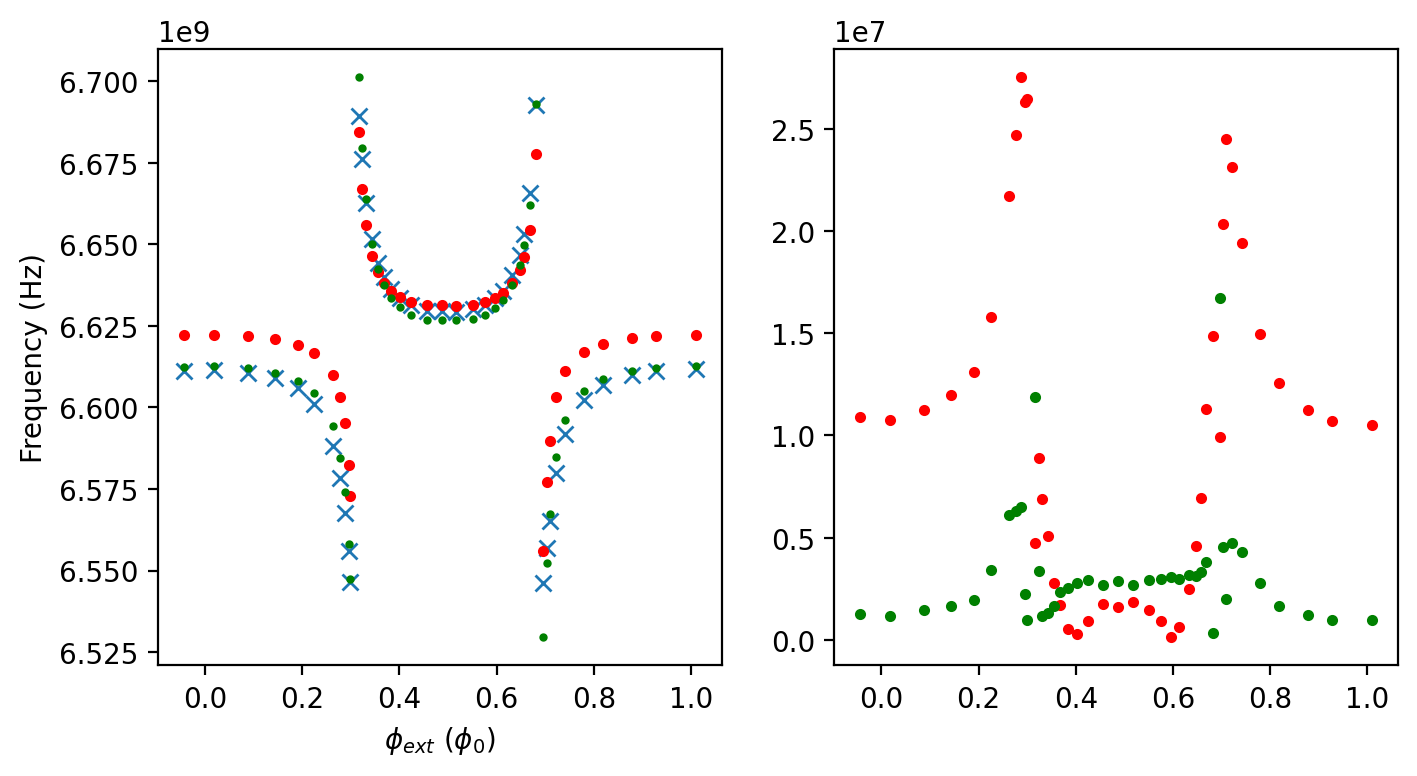

In [485]:
ω_opt = r_q_av_cross_single_spectrum(parameters, data_set, out='spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax1.plot(φ_ext_exp, ω_guess, '.r')
ax1.plot(φ_ext_exp, ω_opt, 'g.', markersize=4)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax2.plot(φ_ext_exp, np.abs(ω_guess - ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt   - ω_exp), 'g.')

# Qubit 1 - Resonator 1 avoided level crossing [Single circuit cooldown 2]

In [335]:
experiment_name = 'qubit_1_resonator_1_avoided_level_crossing_single_circuit_2'

### Load data

In [494]:
with open(os.getcwd() + data_dir + r'/current_q1_single_circuit_2_crossings.pkl', 'rb') as f:
    current_q1_single_circuit_2_crossings = pickle.load(f)
with open(os.getcwd() + data_dir + r'/freq_q1_single_circuit_2_crossings.pkl', 'rb') as f:
    freq_q1_single_circuit_2_crossings = pickle.load(f)
I0 = (0.00825 + 0.00762)/5
Iss = 0.0013
phase_q1_crossings_CD1 = (current_q1_single_circuit_2_crossings - Iss + I0/2)/I0
φ_ext_exp = phase_q1_crossings_CD1
ω_exp = freq_q1_single_circuit_2_crossings

## Define cost function

In [495]:
def r_q_av_cross_single_spectrum(free_args, data_set, out='error'):
    CR, LR, EJ, Δ = free_args
    φ_ext_exp, ω_exp, CF, LF, crossing_index_1, crossing_index_2 = data_set
    Lq, Lr = sq_ext.LF_LR_eff_to_Lq_Lr(LF=LF_1,LR=LR,Δ=Δ)

    resonator = sq_ext.sq_resonator(C_R_eff=CR, L_R_eff=LR)
    qubit = sq_ext.sq_fluxonium(C_F_eff=CF, L_F_eff=LF, EJ=EJ)
    loop  = qubit.loops[0]

    ω_vs_φ_ext = np.zeros([len(φ_ext_exp),2])
    for i, φ_ext in enumerate(φ_ext_exp):
        loop.set_flux(φ_ext)
        H = sq_ext.hamiltonian_qubit(fluxonium=qubit, resonator=resonator, Lq=Lq, Lr=Lr, Δ=Δ )
        ω_vs_φ_ext[i] = sq_ext.diag(H, 3, remove_ground=True)[0][1:]
    ω_vs_φ_ext = np.concatenate( [ω_vs_φ_ext[0:crossing_index_1,0] , ω_vs_φ_ext[crossing_index_1:-crossing_index_2,1], ω_vs_φ_ext[-crossing_index_2:,0]]) * 1e9 
    
    if out == 'error':
        return np.sum((ω_vs_φ_ext - ω_exp)**2)
    elif out =='spectrum':
        return ω_vs_φ_ext 

## Guess parameters and set bounds

In [496]:
_, CF_1, LF_1, _, _, _, _ = sq_ext.get_experimental_parameters('qubit 1', Δ=0.1, LR=100)

# experiment_file = os.getcwd() + opt_dir + 'qubit_1' + '.npz'
# data = np.load(experiment_file)
# EJ = data['parameters'][-1]
EJ = 6.24
Δ = 0.8
LR = 95
CR = 6.07

In [500]:
crossing_index_1 = 10
crossing_index_2 = 10
parameters_guess = [CR, LR, EJ, Δ]
data_set = ([φ_ext_exp, ω_exp, CF_1, LF_1,crossing_index_1, crossing_index_2 ])
bounds= ((2,25),(30,170),(4,15),(0,2))

## Plot guess to check

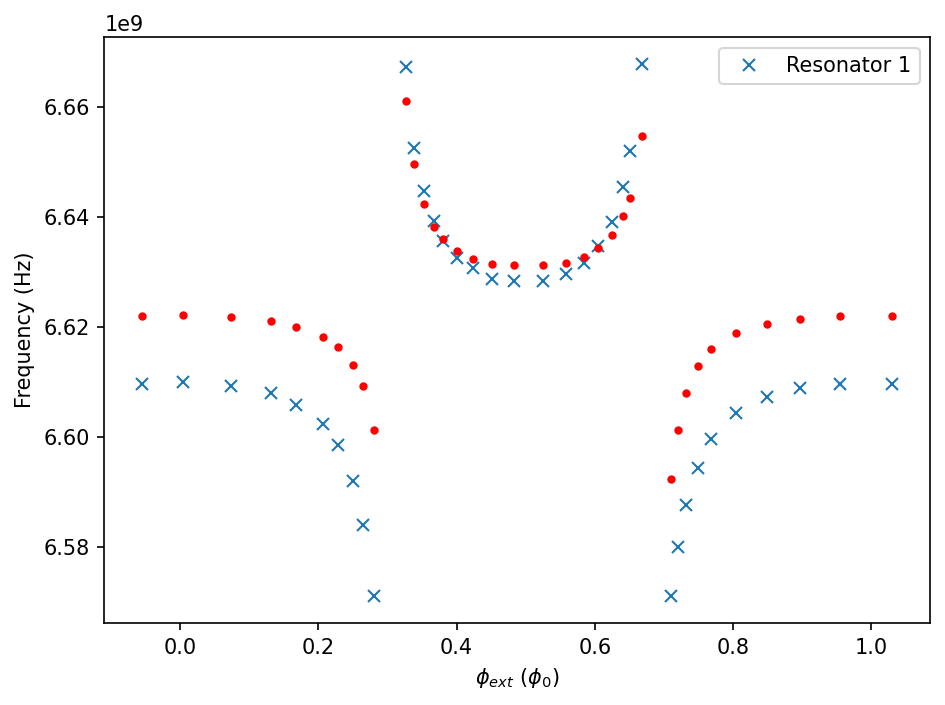

In [501]:
ω_guess = r_q_av_cross_single_spectrum(parameters_guess, data_set, out='spectrum')

fig, ax = plt.subplots(dpi=150)
ax.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax.plot(φ_ext_exp, ω_guess, '.r')

ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('$\phi_{ext}$ ($\phi_0$)')
ax.legend()
fig.tight_layout()

## Optimize or load previous optimization

In [502]:
load = False

experiment_file = os.getcwd() + opt_dir + experiment_name + '.npz'
if load:
    data = np.load(experiment_file)
    parameters   = data['parameters']
    parameters_guess = data['parameters_guess']
    data_set      = (data['data_set_arr'], data['data_set_sc'])
    bounds          = (data['bounds'])
else:
    parameters = minimize(r_q_av_cross_single_spectrum, parameters_guess, data_set, bounds=bounds).x
    np.savez(experiment_file, parameters=parameters, parameters_guess = np.array(parameters_guess), data_set_arr=np.array(data_set[0:2]), 
             data_set_sc=np.array(data_set[2:]), bounds=np.array(bounds))
    

## Plot fits and errors

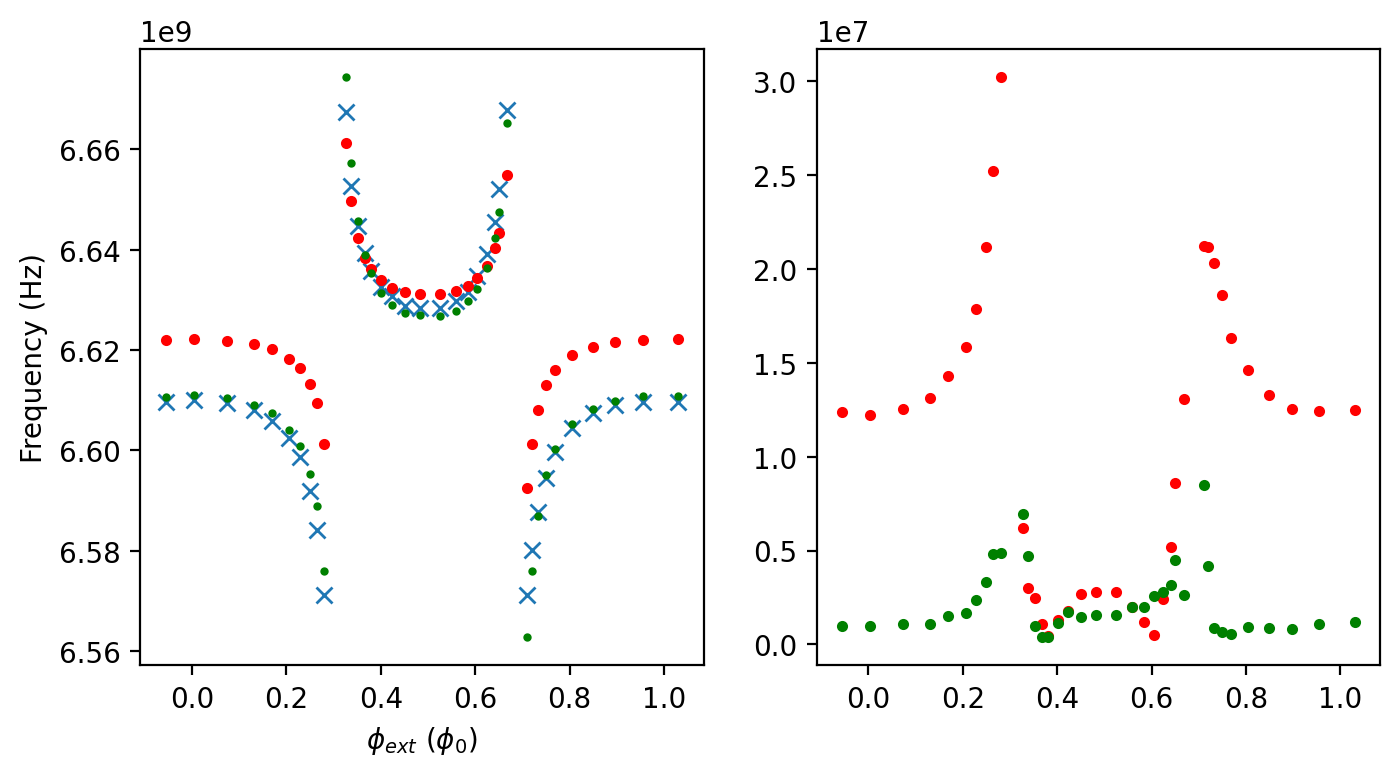

In [503]:
ω_opt = r_q_av_cross_single_spectrum(parameters, data_set, out='spectrum')

fig, (ax1, ax2 )= plt.subplots(ncols=2, dpi=200, figsize=[8,4])
ax1.plot(φ_ext_exp, ω_exp, marker='x', ls='', label='Resonator 1')
ax1.plot(φ_ext_exp, ω_guess, '.r')
ax1.plot(φ_ext_exp, ω_opt, 'g.', markersize=4)
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('$\phi_{ext}$ ($\phi_0$)')

ax2.plot(φ_ext_exp, np.abs(ω_guess - ω_exp), 'r.')
ax2.plot(φ_ext_exp, np.abs(ω_opt   - ω_exp), 'g.')

In [504]:
parameters

array([ 6.07788695, 95.07941178,  6.20080768,  1.06088475])

In [520]:
parameters

array([ 6.07828337, 95.05794044,  6.24056888,  0.99983018])